# Persistance

In [1]:
# Import Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as  pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
# plot styles/formatting
import seaborn as sns
import cmocean
import cmocean.cm as cmo


In [2]:
# Set up paths
home = Path.home()                     # users home directory
root = home / 'repos' / 'montini-phd'  # project root directory
path_to_data = root/'data'           # project data -- read only
path_to_out = root/'out'             # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = root/'figs'           # figures

# Set path to module directory
path_to_mods = os.fspath(root/'modules')
sys.path.append(path_to_mods)

# Import User Modules
from timeseries import persistence


In [3]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

## Read data

In [4]:
# Read CSV data into pandas DataFrame
infile = path_to_out / 'sallj-types-ndjfm.csv'
df= pd.read_csv(infile)

# set up datetime index
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')

# create llj column [1=llj, 0= no llj]
df['LLJ'] = 0
idx = (df['LLJ_CAT'] >= 1)
df.loc[idx, 'LLJ'] = 1

# show df
df.head(10)

,LLJ_CAT,LLJ
DATE,,
1979-11-01 09:00:00,0,0
1979-11-02 09:00:00,0,0
1979-11-03 09:00:00,0,0
1979-11-04 09:00:00,0,0
1979-11-05 09:00:00,0,0
1979-11-06 09:00:00,0,0
1979-11-07 09:00:00,4,1
1979-11-08 09:00:00,2,1
1979-11-09 09:00:00,0,0


## Count/tag LLJ events (group consecutive LLJ days)

In [5]:

# Set up variables/arrays
df['LLJ_TAGS'] = 0              # new df column for storing llj event tags
years = np.arange(1979, 2017)   # list of years
nyrs = len(years)               # number of years
run_count = 0                   # running count of llj events

# Loop to count and tag LLJ events each year
for k in range(nyrs-1):

    # index first and last day of season
    start_date = pd.to_datetime("{}-11-01 9:00".format(years[k]))
    end_date = pd.to_datetime("{}-03-31 9:00".format(years[k+1]))

    # select rows by date using df.loc[start_date:end_date]
    tmp = df.loc[start_date:end_date]
    
    # extract llj time series
    x = tmp['LLJ'].values

    # function to count/tag consecutive events in x
    tags, duration = persistence(x)
    count = tags.max()

    # Update tags to be continuous from year to year
    idx = (tags > 0)        
    tags[idx] += run_count

    # Store tags in df
    df.loc[start_date:end_date, 'LLJ_TAGS'] = tags
    
    # update running count
    run_count += count

    
# Print results
print("Number of independent LLJ events: ", run_count)
df.head(15)


Number of independent LLJ events:  677


,LLJ_CAT,LLJ,LLJ_TAGS
DATE,,,
1979-11-01 09:00:00,0,0,0
1979-11-02 09:00:00,0,0,0
1979-11-03 09:00:00,0,0,0
1979-11-04 09:00:00,0,0,0
1979-11-05 09:00:00,0,0,0
1979-11-06 09:00:00,0,0,0
1979-11-07 09:00:00,4,1,1
1979-11-08 09:00:00,2,1,1
1979-11-09 09:00:00,0,0,0


## Calculate persistence of LLJ events
- [ ] convert to function in time_series module

In [8]:

# set up arrays/variables
x = df['LLJ_TAGS'].values           # array of tagged events
xmax = x.max()                      # max event tag (xmax = run_count)
event_id = np.arange(xmax) + 1      # list of events [1,2,3...xmax]
duration = np.empty(xmax, dtype=int)  # arr for storing event persistence

# Loop through each LLJ event
for k in range(xmax):
    # find event indices
    idx = np.where(x == event_id[k])
    # determine length (persistence) of event
    duration[k] = len(idx[0])
    
# Save results to new dataframe
data = {'event_id':event_id, 'persis':duration}
df2 = pd.DataFrame(data)
df2 = df2.set_index('event_id')

# print stats
df2.describe()

,persis
count,677.000000
mean,2.607090
std,1.915943
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,14.000000


## Create Figure

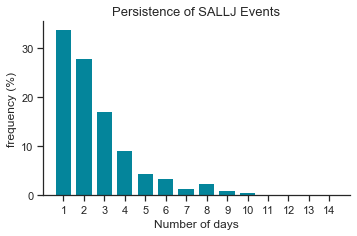

In [29]:
# Figure: Persistence vs. Frequency

# counts / frequencies
bcounts = np.bincount(duration)
bfreqs = bcounts / xmax * 100
xbins = np.arange(len(bcounts))

# set seaborn style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})
#sns.set_style("whitegrid", {'patch.force_edgecolor':False})

# create figure
fig, ax = plt.subplots(figsize=(5.5,3.2))
ax.bar(xbins, bfreqs, width=0.75, color="#04859B")
sns.despine()

# set plot properties
ax.set_xlim(0, xbins.max()+1)
ax.set_xticks(xbins[1:])
ax.set_title('Persistence of SALLJ Events', fontsize=13)
ax.set_xlabel('Number of days')
ax.set_ylabel('frequency (%)')

#fig.tight_layout()
plt.savefig(home/'Desktop'/'fig9.png', dpi=150)
plt.show()


In [17]:
bmax = duration.max()
bins = np.arange(bmax+1)
bcounts = np.bincount(duration)

total_count = sum(bcounts)
print(total_count)
bpercent = bcounts / total_count

for i in range(bmax+1):
    print(bins[i], bcounts[i], bpercent[i]*100)


677
0 0 0.0
1 228 33.67799113737075
2 187 27.621861152141804
3 114 16.838995568685377
4 61 9.010339734121123
5 29 4.283604135893649
6 23 3.3973412112259975
7 9 1.329394387001477
8 15 2.2156573116691285
9 6 0.8862629246676514
10 3 0.4431314623338257
11 0 0.0
12 0 0.0
13 1 0.14771048744460857
14 1 0.14771048744460857
